# Auto-encoders for image compression, generation and denoising



### Imports python

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Import pytorch:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
#from torch.utils.tensorboard import SummaryWriter

/home/denis/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# 1. Implementing an auto-encoder on MNIST image dataset

## 1.1 Data loading and visualization

Let's start with data preparation. We get the data from torchvision and normalize them. They are already separated into a training set and a test set. 

shape X train :  torch.Size([60000, 28, 28])
shape X test :  torch.Size([10000, 28, 28])


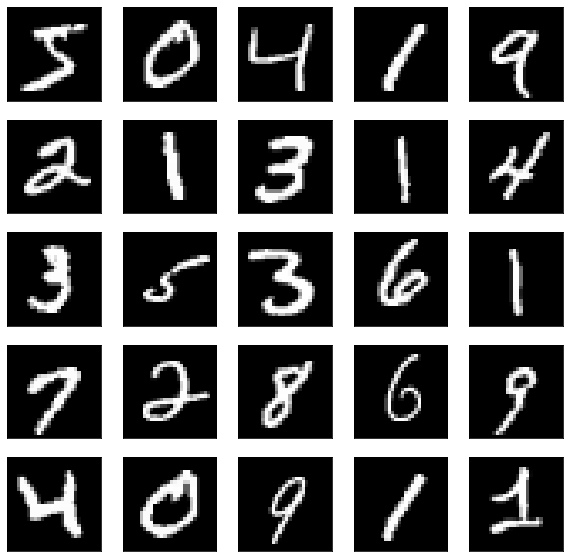

In [2]:
# Get MNIST data
X_train = torchvision.datasets.MNIST(root='./data', train=True, download=True).data
X_test = torchvision.datasets.MNIST(root='./data', train=False, download=True).data

# Normalise between 0 and 1
X_train = (X_train/255.).type(torch.FloatTensor)
X_test = (X_test/255.).type(torch.FloatTensor)

print('shape X train : ', X_train.shape)
print('shape X test : ', X_test.shape)

# Create datasets
mnistTrainSet_clean = TensorDataset(X_train, X_train)
mnistTestSet_clean = TensorDataset(X_test, X_test)

# Display a few images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.gray()
    plt.imshow(X_train[i],vmin=0,vmax=1)
    

## 1.2 Auto-encoder with 1 dense hidden layer

### To do:
1. What will be the input and output dimension for an auto-encoder network trained on MNIST dataset?
2. Implement a network class ```AutoEncoderMLP``` which takes the desired size of the latent space as a parameter and defines a fully connected auto-encoder with 1 hidden layer. You will take the default value of 32 as the latent space size.
3. Define the cost function to be minimized
4. Define the optimizer and the training procedure, and train your network on the MNIST training set
5. Visualise the reconstructions obtained on the test set
6. Modify the size of the latent space and observe its influence on the reconstructed images


### Model definition

In [3]:
class AutoEncoderMLP(nn.Module):
    def __init__(self,embedding_dim = 32):
        super(AutoEncoderMLP, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(start_dim = 1),
            nn.Linear(784, embedding_dim),
            nn.ReLU()     
        )  
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 784),
            nn.Sigmoid()        
        )
            
    def encode(self, x):
        x = self.encoder(x)
        return x
            
    def decode(self, x):
        x = self.decoder(x)
        x = x.reshape((x.shape[0],28,28)) 
        return x
            
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)              
        return x

torch.manual_seed(0)

In [4]:
# Latent space dimension (embedding)
embedding_dim = 32

# Model creation
modelMLP = AutoEncoderMLP(embedding_dim=embedding_dim)

# Print architecture:
print(modelMLP)

AutoEncoderMLP(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


### Training Configuration

We define the loss function, hyperparameters and optimizer to use for training

In [5]:
# Hyperparameters
N_epochs = 10
batch_size = 256
learning_rate = 0.001

# dataloaders
mnistTrainLoader = DataLoader(mnistTrainSet_clean, batch_size=batch_size,shuffle=True, num_workers=0)

# Loss function
loss_function = nn.MSELoss() # Fill here

# Optimizer
optimizer = optim.Adam(modelMLP.parameters(), lr = learning_rate)# Fill here

### Training Procedure

The training procedure will be defined in the ```train``` function below

In [6]:
# Training procedure for a model, using a dataloader, optimiser and number of epochs
def train(model, data_loader, opt, n_epochs):
    losses = []  
    i=0
    for epoch in range(n_epochs):  # Loop over epochs
        running_loss = 0.0

        for features, labels in data_loader:      

            prediction = model(features)
            loss = loss_function(prediction, labels)
            losses.append(loss.item())
            opt.zero_grad()
            loss.backward()
            opt.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    
                print('[Epoch : %d, iteration: %5d] loss: %.3f'%
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
            i+=1   

    print('Training done')
    return losses

### Training

In [7]:
losses = train(modelMLP, mnistTrainLoader, optimizer, N_epochs)

[Epoch : 1, iteration:   100] loss: 0.105
[Epoch : 1, iteration:   200] loss: 0.056
[Epoch : 2, iteration:   300] loss: 0.028
[Epoch : 2, iteration:   400] loss: 0.038
[Epoch : 3, iteration:   500] loss: 0.010
[Epoch : 3, iteration:   600] loss: 0.030
[Epoch : 3, iteration:   700] loss: 0.028
[Epoch : 4, iteration:   800] loss: 0.024
[Epoch : 4, iteration:   900] loss: 0.024
[Epoch : 5, iteration:  1000] loss: 0.013
[Epoch : 5, iteration:  1100] loss: 0.021
[Epoch : 6, iteration:  1200] loss: 0.005
[Epoch : 6, iteration:  1300] loss: 0.019
[Epoch : 6, iteration:  1400] loss: 0.019
[Epoch : 7, iteration:  1500] loss: 0.016
[Epoch : 7, iteration:  1600] loss: 0.017
[Epoch : 8, iteration:  1700] loss: 0.009
[Epoch : 8, iteration:  1800] loss: 0.017
[Epoch : 9, iteration:  1900] loss: 0.003
[Epoch : 9, iteration:  2000] loss: 0.016
[Epoch : 9, iteration:  2100] loss: 0.016
[Epoch : 10, iteration:  2200] loss: 0.013
[Epoch : 10, iteration:  2300] loss: 0.015
Training done


### Visualisation

#### Display the evolution of the loss during training

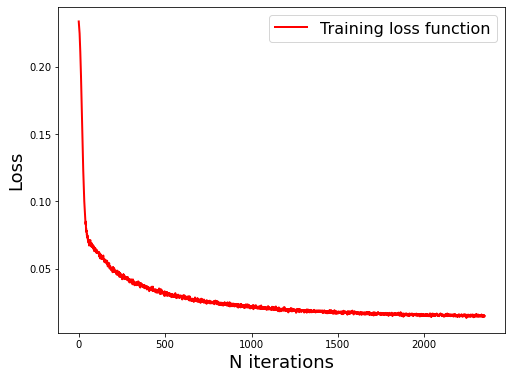

In [8]:
def display(losses,label='Training loss function'):
    # Display loss evolution
    fig, axes = plt.subplots(figsize=(8,6))
    axes.plot(losses,'r-',lw=2,label=label)
    axes.set_xlabel('N iterations',fontsize=18)
    axes.set_ylabel('Loss',fontsize=18)
    plt.legend(loc='upper right',fontsize=16)

# # Display loss evolution
display(losses)

### Display image reconstructions

In [9]:
def display_reconstructions(img_initial, img_reconstructed, n=8):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # image original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(img_initial[i,:,:].reshape(28, 28),vmin=0,vmax=1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # image reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(img_reconstructed[i,:,:])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

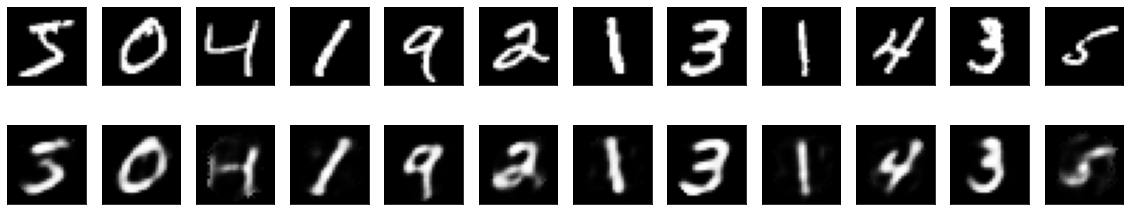

In [10]:
# Compute and display example reconstructed images on the training dataset
n=12
# FILL HERE:
# Compute reconstructed images
reconstructed_images = modelMLP(X_train[:n,:,:])
# Display:
display_reconstructions(X_train[:n,:,:], reconstructed_images.detach().numpy(), n)

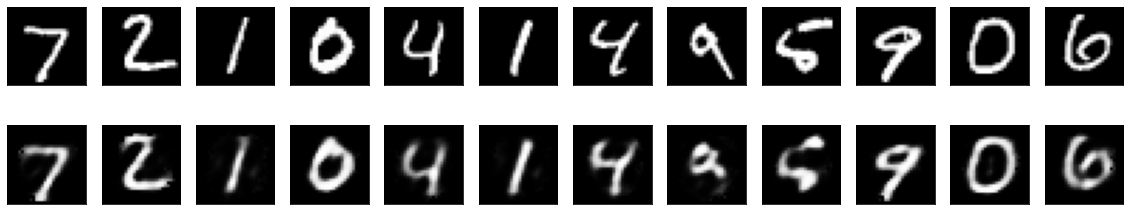

In [11]:
# Compute and display example reconstructed images on the test dataset
n=12
# FILL HERE:
# Compute reconstructed images
reconstructed_images = modelMLP(X_test[:n,:,:])
# Display:
display_reconstructions(X_test[:n,:,:], reconstructed_images.detach().numpy(), n)

## 1.4 Image generation through interpolation on the latent space

### To do: 

7. Choose 2 images of size $28\times$28 to interpolate and call them ``img1`` and ``img2``.
8. Calculate the associated $z1$ and $z2$ codes using your previously trained encoder with a code size of 32
9. For different $z$ values between $z1$ and $z2$ (obtained by linear interpolation) calculate the image decoded by your model
10. Display 10 images generated by regular linear interpolation on the latent space.

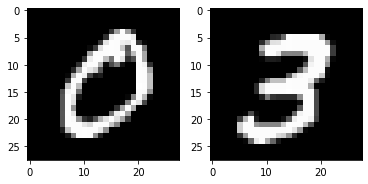

In [12]:
# Choice of images to interpolate
img1 = X_train[1,:,:]   # FILL HERE:
img2 = X_train[7,:,:]    # FILL HERE:

# Display the 2 images
plt.subplot(1,2,1)
plt.gray()
plt.imshow(img1,vmin=0,vmax=1)
plt.subplot(1,2,2)
plt.imshow(img2,vmin=0,vmax=1)

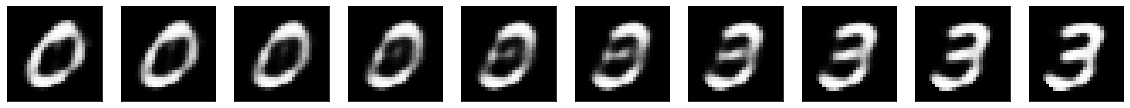

In [13]:
# Compute codes z1 and z2
z1 = modelMLP.encode(img1[None,None,:,:])       # FILL HERE:
z2 = modelMLP.encode(img2[None,None,:,:])     # FILL HERE:

# Computed interpolated images and display
plt.figure(figsize=(20,4))
num = 10
i=0
for k in np.linspace(0,1,num):
    i+=1
    z = k*z2 + (1-k)*z1
    img = modelMLP.decode(z).reshape(28,28)
    plt.subplot(1,num,i)
    plt.gray()
    plt.imshow(img.detach().numpy(),vmin=0,vmax=1)
    plt.xticks([])
    plt.yticks([])

## 1.5 Convolutional auto-encoder
We now want to design an auto-encoder architecture composed of:
* a convolutional encoder
* a decoder based on transposed convolutions

### To do:

11. Propose a convolutional architecture for the **encoder** consisting only of a succession of ``Conv2d`` layers and ``ReLU`` activation: without pooling, but with strides of your choice, so that the final layer of the encoder returns a tensor of size $N \times d \times1$, where $N$ is the batch size, $d$ the number of channels corresponding to the dimension of the latent space. Then build the **decoder** in a similar way with ``ConvTranspose2d`` layers so as to find the correct dimension in the output.


In [14]:
class AutoEncoderCNN(nn.Module):
    def __init__(self, C, embedding_dim):
        super(AutoEncoderCNN, self).__init__()
        # Input shape: [batch, 1, 28, 28]
        self.encoder = nn.Sequential(
            nn.Conv2d(1, C, kernel_size = 5, stride = 1), 
            #shape: [batch, C, 24, 24]
            nn.ReLU(),
            nn.Conv2d(C, C, kernel_size = 5, stride = 2), 
            #shape: [batch, C, 10, 10]
            nn.ReLU(),
            nn.Conv2d(C, C, kernel_size = 3, stride = 2), 
            #shape: [batch, C, 4, 4]
            nn.ReLU(),
            nn.Conv2d(C, embedding_dim, kernel_size = 4, stride = 1)   
            #output shape: [batch, d, 1, 1]
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, C, kernel_size = 4, stride = 1), 
            #shape: [batch, C, 4, 4] 
            nn.ReLU(),
            nn.ConvTranspose2d(C, C, kernel_size = 3, stride = 2, output_padding = 1), 
            #shape: [batch, C, 10, 10] 
            nn.ReLU(),
            nn.ConvTranspose2d(C, C, kernel_size = 5, stride = 2, output_padding = 1), 
            #shape: [batch, C, 24, 24] 
            nn.ReLU(),
            nn.ConvTranspose2d(C, 1, kernel_size = 5, stride = 1) 
            #shape: [batch, 1, 28, 28]
        )  
    def encode(self, x):
        x = encoder(x)
        return x
            
    def decode(self, x):
        x = decoder(x)
        return x
            
    def forward(self, x):
        #shape: [batch, 28, 28] -> #shape: [batch, 1, 28, 28]
        x = self.encoder(x[:,None,:,:])
        x = self.decoder(x)
        #shape: [batch, 1, 28, 28] -> #shape: [batch, 28, 28]
        x = x.reshape((x.shape[0],28,28))        
        return x   


In [15]:
# Network creation
modelcnn = AutoEncoderCNN(C=16,embedding_dim=16)

# Print the architecture
print(modelcnn)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in modelcnn.state_dict():
    print(param_tensor, "\t", modelcnn.state_dict()[param_tensor].size())

AutoEncoderCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 16, kernel_size=(5, 5), stride=(2, 2), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(1, 1))
  )
)
Model's state_dict:
encoder.0.weight 	 torch.Size([16, 1, 5, 5])
encoder.0.bias 	 torch.Size([16])
encoder.2.weight 	 torch.Size([16, 16, 5, 5])
encoder.2.bias 	 torch.Size([16])
encoder.4.weight 	 torch.Size([16, 16, 3, 3])
encoder.4.bias 	 torch.Size([16])
encoder.6.weight 

### Training

In [16]:
# Hyperparameters
N_epochs = 3
batch_size = 256
learning_rate = 0.001

In [17]:
loss_function = nn.MSELoss()# FILL HERE

In [18]:
# Optimiser
optimizer = optim.Adam(modelcnn.parameters(),lr=learning_rate)# FILL HERE

In [19]:
# DataLoader
mnistTrainLoader = DataLoader(mnistTrainSet_clean, batch_size=batch_size,shuffle=True, num_workers=0)

In [20]:
losses = train(modelcnn, mnistTrainLoader, optimizer, N_epochs)

[Epoch : 1, iteration:   100] loss: 0.068
[Epoch : 1, iteration:   200] loss: 0.036
[Epoch : 2, iteration:   300] loss: 0.015
[Epoch : 2, iteration:   400] loss: 0.021
[Epoch : 3, iteration:   500] loss: 0.006
[Epoch : 3, iteration:   600] loss: 0.018
[Epoch : 3, iteration:   700] loss: 0.017
Training done


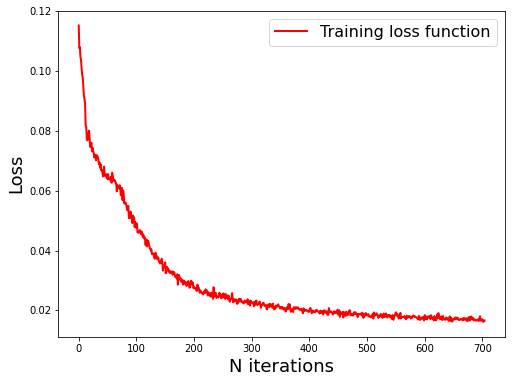

In [21]:
# Display loss
display(losses)

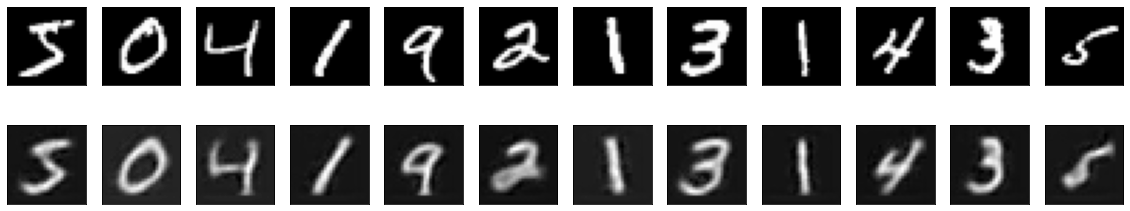

In [22]:
# Compute and display example reconstructed images on the training dataset
n=12
# FILL HERE:
# Compute reconstructed images
reconstructed_images = modelcnn(X_train[:n,:,:])
# Display:
display_reconstructions(X_train[:n,:,:], reconstructed_images.detach().numpy(), n)

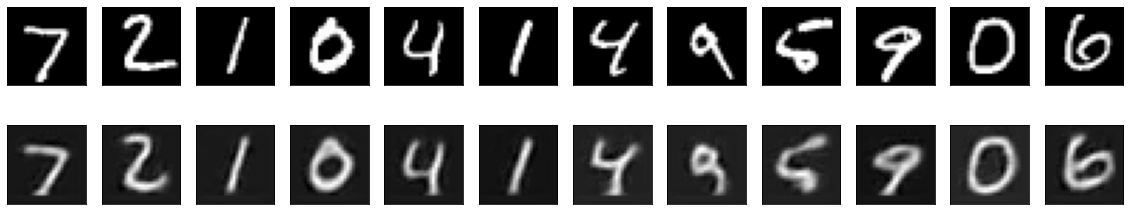

In [23]:
# Compute and display example reconstructed images on the test dataset
n=12
# FILL HERE:
# Compute reconstructed images
reconstructed_images = modelcnn(X_test[:n,:,:])
# Display:
display_reconstructions(X_test[:n,:,:], reconstructed_images.detach().numpy(), n)

# 2. Application to image denoising

We now wish to use an autoencoder for image denoising. In this case, we want the network to return a noise free image at the output for a noisy image at the input.
We will use a new dataset for this

## To do 

12. Complete the dataset construction below by identifying which tensor contains the data and which tensor contains the labels in this application.

13. Build a denoising auto-encoder and train it with this new dataset. Observe the outputs predicted by such a network.

14. Study the denoising performance by varying the initial noise level and the number of neurons in the trained network.

### Denoising dataset preparation

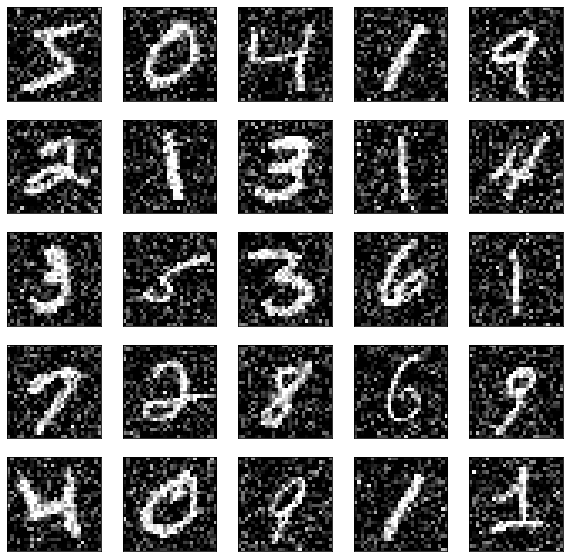

In [24]:
# Noise level (Modify here)
noise_scale = 0.3

# Add noise
noise = np.random.normal(loc=0, scale=noise_scale, size=X_train.shape)
X_train_noisy = X_train + noise
X_train_noisy = np.clip(X_train_noisy, 0., 1.).type(torch.FloatTensor)

noise = np.random.normal(loc=0, scale=noise_scale, size=X_test.shape)
X_test_noisy = X_test + noise
X_test_noisy = np.clip(X_test_noisy, 0., 1.).type(torch.FloatTensor)

# Datasets building

mnistTrainSet_denoise = TensorDataset(X_train_noisy, X_train)# FILL HERE
mnistTestSet_denoise = TensorDataset(X_test_noisy, X_test)# FILL HERE

# Display a few noisy images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_noisy[i])
    plt.gray()

### Building the model

In [25]:
# Build the model
denoiser = AutoEncoderMLP(embedding_dim=128) # FILL HERE
print(denoiser)

AutoEncoderMLP(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


### Train

In [26]:
# Hyperparameters
N_epochs = 10
batch_size = 256
learning_rate = 0.001

In [27]:
# Dataloader
mnistnoisyTrainLoader = DataLoader(mnistTrainSet_denoise, batch_size=batch_size,shuffle=True, num_workers=0)
mnistnoisyTestLoader = DataLoader(mnistTestSet_denoise, batch_size=batch_size,shuffle=True, num_workers=0)

In [28]:
# Optimizer
optimizer = optim.Adam(denoiser.parameters(), lr=learning_rate)# FILL HERE

In [29]:
losses = train(denoiser, mnistnoisyTrainLoader, optimizer, N_epochs)

[Epoch : 1, iteration:   100] loss: 0.079
[Epoch : 1, iteration:   200] loss: 0.044
[Epoch : 2, iteration:   300] loss: 0.021
[Epoch : 2, iteration:   400] loss: 0.027
[Epoch : 3, iteration:   500] loss: 0.006
[Epoch : 3, iteration:   600] loss: 0.019
[Epoch : 3, iteration:   700] loss: 0.017
[Epoch : 4, iteration:   800] loss: 0.015
[Epoch : 4, iteration:   900] loss: 0.014
[Epoch : 5, iteration:  1000] loss: 0.008
[Epoch : 5, iteration:  1100] loss: 0.013
[Epoch : 6, iteration:  1200] loss: 0.003
[Epoch : 6, iteration:  1300] loss: 0.011
[Epoch : 6, iteration:  1400] loss: 0.011
[Epoch : 7, iteration:  1500] loss: 0.010
[Epoch : 7, iteration:  1600] loss: 0.010
[Epoch : 8, iteration:  1700] loss: 0.005
[Epoch : 8, iteration:  1800] loss: 0.010
[Epoch : 9, iteration:  1900] loss: 0.002
[Epoch : 9, iteration:  2000] loss: 0.009
[Epoch : 9, iteration:  2100] loss: 0.009
[Epoch : 10, iteration:  2200] loss: 0.008
[Epoch : 10, iteration:  2300] loss: 0.009
Training done


### Visualisation

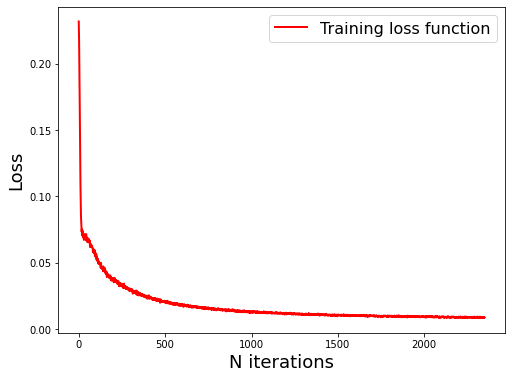

In [30]:
# Display loss:
display(losses)

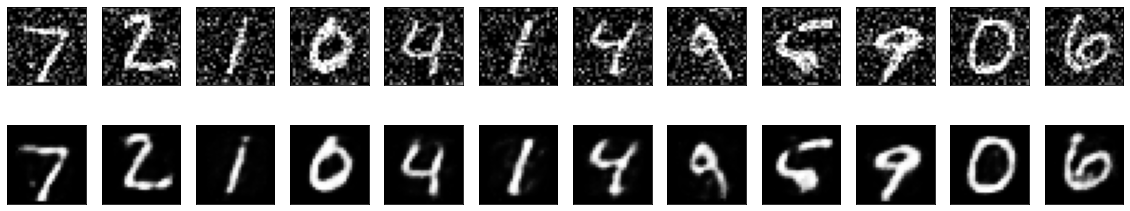

In [31]:
# Compute and display example reconstructed test on the training dataset
n=12
# FILL HERE:
# Compute reconstructed images
reconstructed_images = denoiser(X_test_noisy[:n,:,:])
# Display:
display_reconstructions(X_test_noisy[:n,:,:], reconstructed_images.detach().numpy(), n)

# 3. Noisy image classification

In order to make the link with the previous lab session of yesterday, we now propose to work on the classification of noisy images. 

15. Take one of the classification models previously trained on noiseless images from MNIST, and evaluate its classification performance on noisy images. 

16. Evaluate the classification performance obtained by using a denoiser network trained in the previous section, followed by a classifier network as in the previous tutorial, on a noisy dataset. Here we do not ask to retrain but to use the forward propagations of the 2 networks already trained.

17. To finish, build a new network from the complete architecture corresponding to the succession of the 2 networks from the previous question. This time, train it from start to finish to perform classification on noisy images. Evaluate its classification performance on the noisy test set



In [32]:
# Network
H = 128

# Network Class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(28*28, H),
            nn.ReLU(),
            nn.Linear(H, 10) # 10 digits
        )
                   
    def forward(self, x):
        x = x.reshape(-1,28*28)
        x = self.fc(x)
        return x
    
classifier = Net()
classifier.load_state_dict(torch.load("../MNIST_classification.pt"))



Y_train = torchvision.datasets.MNIST(root='./data', train=True, download=True).targets
_, predictions_noisy_train = torch.max(classifier(X_train_noisy), 1)
_, predictions_denoised_train = torch.max(classifier(denoiser(X_train_noisy)),1 )
labels_train = Y_train

Y_test = torchvision.datasets.MNIST(root='./data', train=False, download=True).targets
_, predictions_noisy_test = torch.max(classifier(X_test_noisy), 1)
_, predictions_denoised_test = torch.max(classifier(denoiser(X_test_noisy)), 1)
labels_test = Y_test

# Accuracy
def accuracy(labels_pred, labels):
    total = labels_pred.shape[0]
    correct = (labels_pred == labels).sum().numpy()
    return np.round(1.0 * correct / total, 4)

print("Noisy train accuracy:", accuracy(predictions_noisy_train, Y_train))
print("Noisy test accuracy:", accuracy(predictions_noisy_test, Y_test))

print("Denoised train accuracy:", accuracy(predictions_denoised_train, Y_train))
print("Denoised test accuracy:", accuracy(predictions_denoised_test, Y_test))

Noisy train accuracy: 0.5994
Noisy test accuracy: 0.6034
Denoised train accuracy: 0.966
Denoised test accuracy: 0.9597
